In [114]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import scipy.sparse as sparse
import implicit
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from implicit.evaluation import precision_at_k, train_test_split
from tqdm import tqdm
from sklearn.metrics import auc, roc_curve
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
import seaborn as sns
import random

# Data Exploration

In [115]:
# Read csv files
df = pd.read_csv('reference/retail.csv')

In [116]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [117]:
# Describe dataset
df.describe(include='all', datetime_is_numeric=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2011 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


## 1. Data cleaning

In [7]:
#Check for NaN values
np.sum(df.isna(),axis =0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

135080 nulls values of customer IDs mean that those customer are new customer or customers that dont have an offical account. All of them will treated as new customers

## 2. EDA

There are canceled invoice in the data, lets take a look at them

In [6]:
df[df['InvoiceNo'].str.contains(r'^C[0-9]*')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [244]:
df[df['CustomerID'] == 17548]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
165024,550755,22585,PACK OF 6 BIRDY GIFT TAGS,24,2011-04-20 12:01:00,1.25,17548.0,United Kingdom
165025,550755,22082,RIBBON REEL STRIPES DESIGN,10,2011-04-20 12:01:00,1.65,17548.0,United Kingdom
165026,550755,22081,RIBBON REEL FLORA + FAUNA,10,2011-04-20 12:01:00,1.65,17548.0,United Kingdom


Look at the table, we can understand that products that are returned have negative quantity in the returning invoice.

Now let's see the distribution of countries of the customers 

In [9]:
# Value counts of event
print(df['Country'].value_counts(normalize=True))

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

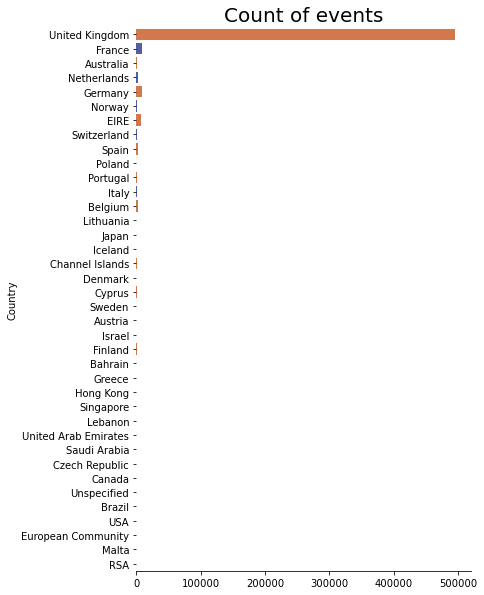

In [7]:
# show figure:
plt.figure(figsize=(6, 10))
# Draw a nested violinplot and split the violins for easier comparison
sns.countplot(data=df, y="Country", 
              palette=[sns.color_palette('icefire')[i] for i in (-1,1)])
sns.despine(left=True)
plt.title("Count of events", fontsize=20)
plt.xlabel("")
plt.show()

We can see that ManyGiftUK has customers from all over the world. however, their dominant market is UK as more than 90% of customers is from this country.

## Event views by day of weeks

In [25]:
# Get df_events and correctly encode the variables
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


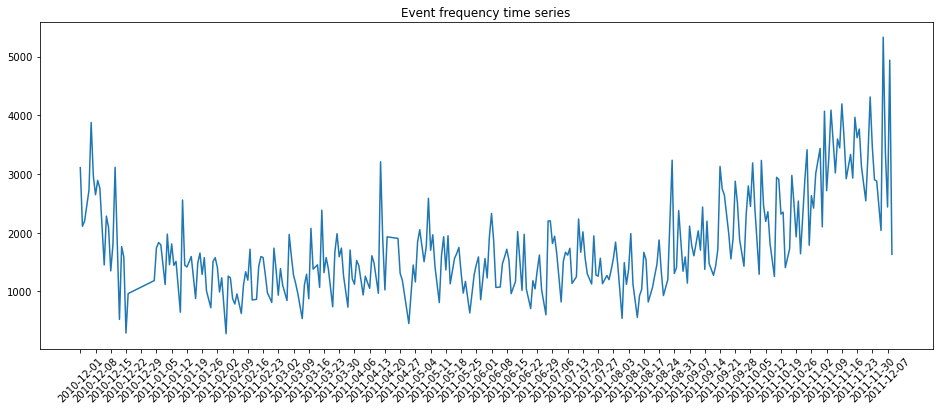

In [103]:
# Visualize number of events per day
data = pd.DatetimeIndex(df['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(16,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.title('Event frequency time series')
plt.show()

In [31]:
# How many weeks does the dataset has?
diff = (data.index.max() - data.index.min())
print(f"The dataset has {diff.days + 1} days, corresponding to {diff.days//7} weeks.")

The dataset has 374 days, corresponding to 53 weeks.


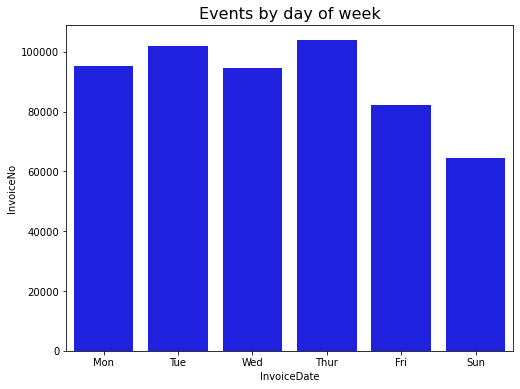

In [59]:
plot_df = df.groupby([df.InvoiceDate.dt.dayofweek]).count()
plot_df =plot_df.rename(index={0:'Mon',1: 'Tue',2: 'Wed',3: 'Thur',4: 'Fri', 6:'Sun'})
# show figure:
plt.figure(figsize=(8, 6))
sns.barplot(y = plot_df['InvoiceNo'], x = plot_df.index, color="blue",
            order=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sun'])
plt.xticks(rotation=0)
plt.title('Events by day of week', fontsize=16)
plt.show()

In [37]:
s = (df.groupby([df.InvoiceDate.dt.dayofweek, 
                 df.InvoiceDate.dt.strftime('%H:00')]).count().rename_axis(index=['DoW','hour']))

<function matplotlib.pyplot.show(close=None, block=None)>

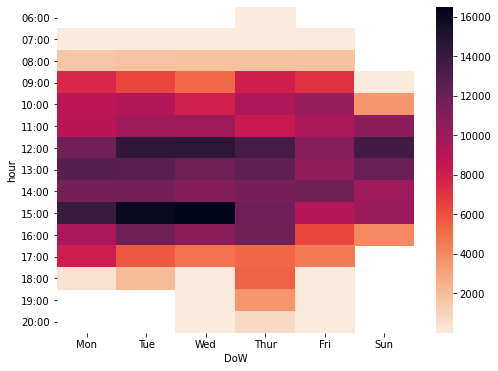

In [65]:
# Monday=0, Sunday=6
plt.figure(figsize=(8, 6))
sns.heatmap(s['InvoiceDate'].unstack(level='DoW'),cmap=sns.cm.rocket_r)
plt.xticks(ticks = [0.5,1.5,2.5,3.5,4.5,5.5],labels=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sun'])
plt.show

# 3. Recommendation system

In [7]:
# users that have an offical account and new users:
new_user = df['CustomerID'].isna()
offical_user = ~df['CustomerID'].isna()

In [8]:
df.loc[offical_user,['StockCode', 'Quantity', 'CustomerID']] 

,StockCode,Quantity,CustomerID
0,85123A,6,17850.0
1,71053,6,17850.0
2,84406B,8,17850.0
3,84029G,6,17850.0
4,84029E,6,17850.0
...,...,...,...
541904,22613,12,12680.0
541905,22899,6,12680.0
541906,23254,4,12680.0
541907,23255,4,12680.0


In [19]:
# use data of offical user, and only relevant feature
data = df.loc[offical_user,['StockCode', 'Quantity', 'CustomerID']] 
# convert customer ID to int value
data['CustomerID'] = data.CustomerID.astype(int)
# group customer purchases by product together
data = data.groupby(['CustomerID', 'StockCode']).sum().reset_index() 
# replace a sum of zero purchases with 1 to save the interaction
data.Quantity.loc[data['Quantity'] == 0] = 1 
# only get customers where purchase totals were positive, as the customer having negative data is posibly error or missing of data
data = data[data['Quantity']>0]

C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [20]:
import scipy.sparse as sparse
customers = list(np.sort(data.CustomerID.unique())) # Get our unique customers
print(f'Number of customers: {len(customers)}')
products = list(data.StockCode.unique()) # Get our unique products that were purchased
print(f'Number of items: {len(products)}')
quantity = list(data.Quantity) # All of our purchases

rows = data.CustomerID.astype('category').cat.codes 
# Get the associated row indices
cols = data.StockCode.astype('category').cat.codes 

# map each item and user category to a unique numeric code
user_map = dict(zip(data.CustomerID.astype('category'), data.CustomerID.astype('category').cat.codes))
item_map = dict(zip(data.StockCode.astype('category'), data.StockCode.astype('category').cat.codes))

# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(customers), len(products)))

Number of customers: 4338
Number of items: 3664


In [21]:
def get_sparsity(csr_matrix):
    matrix_size = csr_matrix.shape[0]*csr_matrix.shape[1] # Number of possible interactions in the matrix
    num_purchases = len(csr_matrix.nonzero()[0]) # Number of items interacted with
    sparsity = 100*(1 - (num_purchases/matrix_size))
    return sparsity

get_sparsity(purchases_sparse)

98.32190920694744

### Create the train and test Rating Matrices

In [29]:
train, test = train_test_split(purchases_sparse)

In [30]:
print("Train dataset sparsity:", get_sparsity(train))
print("Test dataset sparsity:", get_sparsity(test))

Train dataset sparsity: 98.65758650576504
Test dataset sparsity: 99.6643227011824


## ALS model

In [31]:
alpha = 15
model = AlternatingLeastSquares(factors=20,regularization = 0.1, iterations = 50)
model.fit((train.T*alpha).astype('double'))

In [33]:
def scoring_function(model, train, test, k = 10):
    # Get recommend matrix from the trained model
    recommendations = model.recommend_all(train.tocsr())
    # Get the array of user - item for test set
    nonzero_inds = test.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    actual_test = pd.DataFrame({"customer":nonzero_inds[0],"items":nonzero_inds[1],"ratings": test.data})
    
    precisions = []
    recalls = []
    for i in actual_test.customer.unique():
        top_k = actual_test[actual_test.customer == i]['items']
        precision = float(len(set(top_k ) & set(recommendations[i]))) / float(k)
        recall = float(len(set(top_k ) & set(recommendations[i]))) / len(set(top_k))
        precisions.append(precision)
        recalls.append(recall)
    # hits percentage
    hits_rate = 1-np.sum(pd.Series(precisions) == 0)/len(precisions)
    return np.mean(precisions), np.mean(recalls) , hits_rate 

In [34]:
scoring_function(model, train, test, k = 10)

(0.04972812654473554, 0.07825919726917316, 0.3620860108749382)

## LightFM model

In [59]:
# Instantiate and train the model
model_lfm =    LightFM(no_components=20,
                    loss='warp',
                    learning_rate=0.03,
                    learning_schedule='adadelta')
model_lfm.fit(train, epochs=30, num_threads=2)
# Evaluate the trained model
test_precision = precision_at_k(model_lfm,test, k=10).mean()

In [60]:
precision_at_k(model_lfm,test, k=10)

array([0. , 0.1, 0. , ..., 0. , 0.3, 0. ], dtype=float32)

In [61]:
test_precision

0.060534712

### Get items and users recommendations

In [56]:
def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

In [211]:
# recommend items for a user. 
# the recommended items have the largest inner product with the user vector
user_id = list(user_map.keys())[0]
recommendations = model.recommend(user_map[user_id], train)
list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))

[('23165', 0.13002),
 ('23167', 0.1185437),
 ('22963', 0.10936492),
 ('22962', 0.10562581),
 ('23296', 0.09719646),
 ('23295', 0.09454669),
 ('23294', 0.09125638),
 ('23171', 0.088933595),
 ('23172', 0.08791849),
 ('23163', 0.087668486)]

In [212]:
# find related items
# the related items have the largest inner product with the item vector
item_id = list(item_map.keys())[0]
related = model.similar_items(item_map[item_id])
list(map(lambda x: (get_keys(x[0], item_map), x[1]), related))

[('23166', 0.99999994),
 ('23165', 0.99598926),
 ('23167', 0.8759992),
 ('22963', 0.83874017),
 ('22990', 0.82699054),
 ('22962', 0.81826234),
 ('22841', 0.811414),
 ('22989', 0.8069587),
 ('22978', 0.7859058),
 ('23296', 0.7683371)]

In [113]:
# show the top 10 items that explain the recommended item to the user
# It is possible to write the LVM as a linear function between preferences and past actions.
# We can then see what are the actions associated with the highest contributions to the given recommendation.
score, contributions, user_weights = als_model.explain(user_map[user_id], 
                                                       user_item_train,
                                                       item_map[item_id])
print("The score of the user/item pair is: ", score)
print("The top N (itemid, score) contributions for this user/item pair are:\n", list(map(lambda x: (get_keys(x[0], item_map), x[1]), contributions)))

The score of the user/item pair is:  0.8557548498846045
The top N (itemid, score) contributions for this user/item pair are:
 [('22633', 0.6626597321091531), ('22632', 0.14469382699728614), ('82494L', 0.03247171360359028), ('21068', 0.016841238117015163), ('85123A', 0.016821293417562735), ('84406B', 0.01659400823449355), ('84029E', 0.011619799534802626), ('22411', 0.011306528299341922), ('20679', 0.009620781392809887), ('71477', 0.006031500369257424)]


# ALS model with engineered input

In [10]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [8]:
# users that have an offical account and new users:
new_user = df['CustomerID'].isna()
offical_user = ~df['CustomerID'].isna()

In [9]:
df.loc[offical_user,['StockCode', 'Quantity', 'CustomerID']] 

,StockCode,Quantity,CustomerID
0,85123A,6,17850.0
1,71053,6,17850.0
2,84406B,8,17850.0
3,84029G,6,17850.0
4,84029E,6,17850.0
...,...,...,...
541904,22613,12,12680.0
541905,22899,6,12680.0
541906,23254,4,12680.0
541907,23255,4,12680.0


In [33]:
# use data of offical user, and only relevant feature
data = df.loc[offical_user,['StockCode', 'Quantity', 'CustomerID']] 
# convert customer ID to int value
data['CustomerID'] = data.CustomerID.astype(int)
# group customer purchases by product together
data = data.groupby(['CustomerID', 'StockCode']).sum().reset_index() 

# replace a sum of zero purchases with 1 to save the interaction
data.Quantity.loc[data['Quantity'] == 0] = 1 
# only get customers where purchase totals were positive, as the customer having negative data is posibly error or missing of data
data = data[data['Quantity']>0]
# get log 10 of the quantity
data['Quantity'] = data['Quantity'].map(lambda x: math.ceil(np.log10(x+1)))

C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [35]:
customers = list(np.sort(data.CustomerID.unique())) # Get our unique customers
print(f'Number of customers: {len(customers)}')
products = list(data.StockCode.unique()) # Get our unique products that were purchased
print(f'Number of items: {len(products)}')
quantity = list(data.Quantity) # All of our purchases

rows = data.CustomerID.astype('category').cat.codes 
# Get the associated row indices
cols = data.StockCode.astype('category').cat.codes 

# map each item and user category to a unique numeric code
user_map = dict(zip(data.CustomerID.astype('category'), data.CustomerID.astype('category').cat.codes))
item_map = dict(zip(data.StockCode.astype('category'), data.StockCode.astype('category').cat.codes))

# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(customers), len(products)))

Number of customers: 4338
Number of items: 3664


In [36]:
def get_sparsity(csr_matrix):
    matrix_size = csr_matrix.shape[0]*csr_matrix.shape[1] # Number of possible interactions in the matrix
    num_purchases = len(csr_matrix.nonzero()[0]) # Number of items interacted with
    sparsity = 100*(1 - (num_purchases/matrix_size))
    return sparsity

get_sparsity(purchases_sparse)

98.32190920694744

### Create the train and test Rating Matrices

In [37]:
train, test = train_test_split(purchases_sparse)

In [38]:
print("Train dataset sparsity:", get_sparsity(train))
print("Test dataset sparsity:", get_sparsity(test))

Train dataset sparsity: 98.65893918071436
Test dataset sparsity: 99.66297002623308


## ALS model

In [39]:
alpha = 40
model = AlternatingLeastSquares(factors=20,regularization = 0.1, iterations = 50)
model.fit((train.T*alpha).astype('double'))

In [41]:
scoring_function(model, train, test, k = 10)

(0.07547216090262449, 0.10625425391709024, 0.4844248221731665)

## LightFM model

In [59]:
# Instantiate and train the model
model_lfm =    LightFM(no_components=20,
                    loss='warp',
                    learning_rate=0.03,
                    learning_schedule='adadelta')
model_lfm.fit(train, epochs=30, num_threads=2)
# Evaluate the trained model
test_precision = precision_at_k(model_lfm,test, k=10).mean()

In [60]:
precision_at_k(model_lfm,test, k=10)

array([0. , 0.1, 0. , ..., 0. , 0.3, 0. ], dtype=float32)

In [61]:
test_precision

0.060534712

# Evaluation
**Note**: We are measuring how well the model will rank the items in the test set for a user, given different items in the training set i.e. **the train and test set have the same users**. We are not making inference for new users that didn't appear in the training set. For new users in production, there is a `recalculate_user` method which can be used for generating recommendations without recalculating the whole model. Also, the `recommend(recalculate_user=True)` method allows the model to recommend for new users on the fly ([github issue](https://github.com/benfred/implicit/issues/152)).

In [46]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [47]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(train.T)

In [48]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 'als_model':model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, train.tocsr(), test.tocsr(), K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,lmf_model
precision,0.049406,0.111700
map,0.017130,0.055232
ndcg,0.042064,0.109999
auc,0.515697,0.551883


# Clustering

In [5]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [6]:
# users that have an offical account and new users:
new_user = df['CustomerID'].isna()
offical_user = ~df['CustomerID'].isna()

In [7]:
df.loc[offical_user,['StockCode', 'Quantity', 'CustomerID']] 

,StockCode,Quantity,CustomerID
0,85123A,6,17850.0
1,71053,6,17850.0
2,84406B,8,17850.0
3,84029G,6,17850.0
4,84029E,6,17850.0
...,...,...,...
541904,22613,12,12680.0
541905,22899,6,12680.0
541906,23254,4,12680.0
541907,23255,4,12680.0


In [157]:
# Removing returned products (Invoice numbers starting with C) from the data set
df_clustering = df[~df["InvoiceNo"].str.contains("C", na = False)]
# Removing missing values from the dataset
df_clustering.dropna(inplace = True)
max_date=pd.to_datetime(df_clustering["InvoiceDate"].max())# Last invoice date
# The type of Customer ID variable needs to be turned into an integer for following commands.
df_clustering["CustomerID"] = df_clustering["CustomerID"].astype(int) 

# The type of InvoiceDate variable needs to be turned into datetime for following commands.
df_clustering["InvoiceDate"] = pd.to_datetime(df_clustering["InvoiceDate"])

# Grouping the last invoice dates according to the Customer ID variable, subtracting them from today_date, and assigning them as recency
recency = (max_date-df_clustering.groupby("CustomerID")['InvoiceDate'].max())
recency_df=recency.apply(lambda x: x.days)
recency_df=recency_df.to_frame()
recency_df.columns=['Recency']

# Grouping unique values of invoice date according to customer_id variable and assigning them to freq_df variable
freq_df = df_clustering.groupby("CustomerID")['InvoiceDate'].nunique().to_frame()
freq_df.columns=['Frequency']

df_clustering["TotalPrice"] = df_clustering["Quantity"] * df_clustering["UnitPrice"]

# Grouping and sum up total prices according to each Customer ID
monetary_df = df_clustering.groupby("CustomerID")['TotalPrice'].sum().to_frame()
monetary_df.columns=["Monetary"]

rfm = pd.concat([recency_df, freq_df, monetary_df],  axis=1)
rfm.head()

<ipython-input-157-39e4fa5520ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering.dropna(inplace = True)
<ipython-input-157-39e4fa5520ac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering["CustomerID"] = df_clustering["CustomerID"].astype(int)
<ipython-input-157-39e4fa5520ac>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,Recency,Frequency,Monetary
CustomerID,,,
12346,233,1,77183.60
12347,-90,7,4310.00
12348,-17,4,1797.24
12349,-73,1,1757.55
12350,218,1,334.40


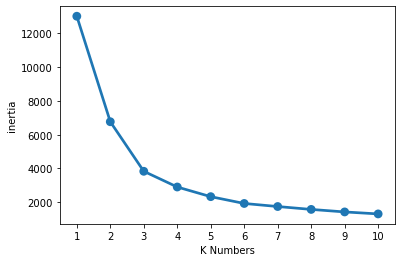

In [158]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x
# apply the function to Recency and MonetaryValue column 
rfm['Recency'] = [neg_to_zero(x) for x in rfm.Recency]
rfm['Monetary'] = [neg_to_zero(x) for x in rfm.Monetary]
# unskew the data
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)
# scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)

inertia = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    inertia[k] = kmeans.inertia_
# plot the WCSS values
sns.pointplot(x = list(inertia.keys()), y = list(inertia.values()))
plt.xlabel('K Numbers')
plt.ylabel('inertia')
plt.show()

In [74]:
clus = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)
# Assign the clusters to datamart
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,K_Cluster
CustomerID,,,,
12346,233,1,77183.60,1
12347,1,7,4310.00,1
12348,1,4,1797.24,1
12349,1,1,1757.55,0
12350,218,1,334.40,2


In [76]:
rfm.groupby('K_Cluster').mean()

,Recency,Frequency,Monetary
K_Cluster,,,
0,1.155583,1.943868,560.692418
1,3.188826,9.364922,5211.946733
2,133.886470,1.567652,484.246774


In [79]:
rfm[rfm['K_Cluster'] == 1].index

Int64Index([12346, 12347, 12348, 12352, 12356, 12359, 12360, 12362, 12364,
            12370,
            ...
            18237, 18241, 18242, 18245, 18257, 18259, 18260, 18272, 18283,
            18287],
           dtype='int64', name='CustomerID', length=1414)

# 3. Recommendation system

In [145]:
# users that have an offical account and new users:
clustered_user = rfm[rfm['K_Cluster'] == 1].index

In [146]:
df['CustomerID'].isin(clustered_user)

0          True
1          True
2          True
3          True
4          True
          ...  
541904    False
541905    False
541906    False
541907    False
541908    False
Name: CustomerID, Length: 541909, dtype: bool

In [147]:
df.loc[offical_user,['StockCode', 'Quantity', 'CustomerID']] 

,StockCode,Quantity,CustomerID
0,85123A,6,17850.0
1,71053,6,17850.0
2,84406B,8,17850.0
3,84029G,6,17850.0
4,84029E,6,17850.0
...,...,...,...
541904,22613,12,12680.0
541905,22899,6,12680.0
541906,23254,4,12680.0
541907,23255,4,12680.0


In [148]:
# use data of offical user, and only relevant feature
data = df.loc[df['CustomerID'].isin(clustered_user),['StockCode', 'Quantity', 'CustomerID']] 
# convert customer ID to int value
data['CustomerID'] = data.CustomerID.astype(int)
# group customer purchases by product together
data = data.groupby(['CustomerID', 'StockCode']).sum().reset_index() 
# replace a sum of zero purchases with 1 to save the interaction
data.Quantity.loc[data['Quantity'] == 0] = 1 
# only get customers where purchase totals were positive, as the customer having negative data is posibly error or missing of data
data = data[data['Quantity']>0]
# get log 10 of the quantity
data['Quantity'] = data['Quantity'].map(lambda x: math.ceil(np.log10(x+1)))

C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [149]:
import scipy.sparse as sparse
customers = list(np.sort(data.CustomerID.unique())) # Get our unique customers
print(f'Number of customers: {len(customers)}')
products = list(data.StockCode.unique()) # Get our unique products that were purchased
print(f'Number of items: {len(products)}')
quantity = list(data.Quantity) # All of our purchases

rows = data.CustomerID.astype('category').cat.codes 
# Get the associated row indices
cols = data.StockCode.astype('category').cat.codes 

# map each item and user category to a unique numeric code
user_map = dict(zip(data.CustomerID.astype('category'), data.CustomerID.astype('category').cat.codes))
item_map = dict(zip(data.StockCode.astype('category'), data.StockCode.astype('category').cat.codes))

# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(customers), len(products)))

Number of customers: 1414
Number of items: 3560


In [151]:
def get_sparsity(csr_matrix):
    matrix_size = csr_matrix.shape[0]*csr_matrix.shape[1] # Number of possible interactions in the matrix
    num_purchases = len(csr_matrix.nonzero()[0]) # Number of items interacted with
    sparsity = 100*(1 - (num_purchases/matrix_size))
    return sparsity

get_sparsity(purchases_sparse)

96.59369387982137

### Create the train and test Rating Matrices

In [152]:
train, test = train_test_split(purchases_sparse)

In [153]:
print("Train dataset sparsity:", get_sparsity(train))
print("Test dataset sparsity:", get_sparsity(test))

Train dataset sparsity: 97.27762503377143
Test dataset sparsity: 99.31606884604993


## ALS model

In [154]:
alpha = 15
model = AlternatingLeastSquares(factors=20,regularization = 0.1, iterations = 50)
model.fit((train.T*alpha).astype('double'))

In [156]:
scoring_function(model, train, test, k = 10)

(0.1448424068767908, 0.09141586218678213, 0.7141833810888252)

- General users (4338): (0.07547216090262449, 0.10625425391709024, 0.4844248221731665)
----
- Cluster 1 (1414): (0.1448424068767908, 0.09141586218678213, 0.7141833810888252)
- Cluster 0 & 2 (2924): (0.06599250936329587, 0.12850947963207632, 0.4520599250936329)

In [143]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [144]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(train.T)

In [131]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 'als_model':model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, train.tocsr(), test.tocsr(), K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,als_model
precision,0.061957,0.155871
map,0.022484,0.076379
ndcg,0.060566,0.160414
auc,0.512001,0.543604
